# [Ravi Raghavan]
# Netflix Stock Prices Notebook
---

# Preamble

In [72]:
# import relevant Python libraries
###
import numpy as np  #import numpy 
import pandas as pd #import pandas
from matplotlib import pyplot as plt    #import pyplot from matplotlib
from IPython.display import display, Latex  #import display and Latex from IPython.display
from sklearn import preprocessing as sklpp #import preprocessing from sklearn with alias sklpp
from sklearn import decomposition as skldecomp  #import decomposition from sklearn with alias skldecomp
from sklearn.model_selection import train_test_split #import train_test_split from sklearn.model_selection
import matplotlib.ticker as mticker #import mticker from matplotlib.ticker
from sklearn.model_selection import cross_validate #import cross_val_score from sklearn.model_selection
from sklearn.linear_model import Ridge, Lasso #import Ridge, Lasso from sklearn.linear_model
import time #import time module
from sklearn.metrics import r2_score #import r2_score from sklearn.metrics
###

# **1. Brief Exploration of Dataset**

In [73]:
netflix_stock_prices = pd.read_csv("NFLX.csv") #read in netflix stock prices into pandas dataframe 
print(netflix_stock_prices.head(10)) #display first two rows of dataframe just to get a feel for what the dataframe contains 

         Date        Open        High         Low       Close   Adj Close  \
0  2018-02-05  262.000000  267.899994  250.029999  254.259995  254.259995   
1  2018-02-06  247.699997  266.700012  245.000000  265.720001  265.720001   
2  2018-02-07  266.579987  272.450012  264.329987  264.559998  264.559998   
3  2018-02-08  267.079987  267.619995  250.000000  250.100006  250.100006   
4  2018-02-09  253.850006  255.800003  236.110001  249.470001  249.470001   
5  2018-02-12  252.139999  259.149994  249.000000  257.950012  257.950012   
6  2018-02-13  257.290009  261.410004  254.699997  258.269989  258.269989   
7  2018-02-14  260.470001  269.880005  260.329987  266.000000  266.000000   
8  2018-02-15  270.029999  280.500000  267.630005  280.269989  280.269989   
9  2018-02-16  278.730011  281.959991  275.690002  278.519989  278.519989   

     Volume  
0  11896100  
1  12595800  
2   8981500  
3   9306700  
4  16906900  
5   8534900  
6   6855200  
7  10972000  
8  10759700  
9   8312400 

_[The first code cell here is to simply load the netflix stock prices data into a pandas dataframe. Then, I will print the dataframe just to get a feel for what the dataframe contains. ]_

In [74]:
n, p = netflix_stock_prices.shape #get shape of dataframe(n: number of rows, p: number of columns)
print(f"Number of Rows in Dataframe: {n}") #print number of rows
print(f"Number of Columns in dataframe: {p}") #print total number of columns in dataframe

Number of Rows in Dataframe: 1009
Number of Columns in dataframe: 7


_[To briefly explore this dataset, the first thing I wanted to do was first calculate the total number of rows in my dataframe and the total number of columns in my dataframe. There are a total of 1009 rows in this dataframe. This means that the dataframe contains data across 1009 different days that the value of the Netflix Stock was measured. There are 7 rows in this dataframe. The first column is "Date" which indicates the date that data was gathered about the Netflix Stock. The second column is "Open" which represents the price at which stock opened. The third column is "High" which represents the peak price of the Netflix Stock for that particular day. The fourth column is "Low" which represents the low price of the Netflix Stock for that particular day. The fifth column is "Close" which represents the closing price of the Netflix Stock for that particular day. The sixth column is "Adjusted Close" which represents the adjusted closed price adjusted for splits, dividends, and capital gains distributions. Finally, the seventh column is "Volume" which represents the volume of Netflix Stock for that particular day. ]_

In [75]:
valuesMissing = netflix_stock_prices.isna().sum().sum() #Compute total number of Cells with Missing Values
print(f"Number of missing values: {valuesMissing}") #print number of cells with missing values

Number of missing values: 0


_[The next step is to calculate the number of cells with missing values(i.e. empty cells). Luckily, our dataset has 0 missing values]_

The column Date can not be represented as a histogram


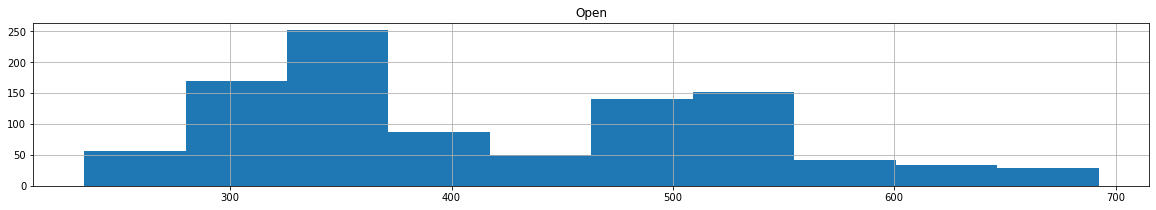

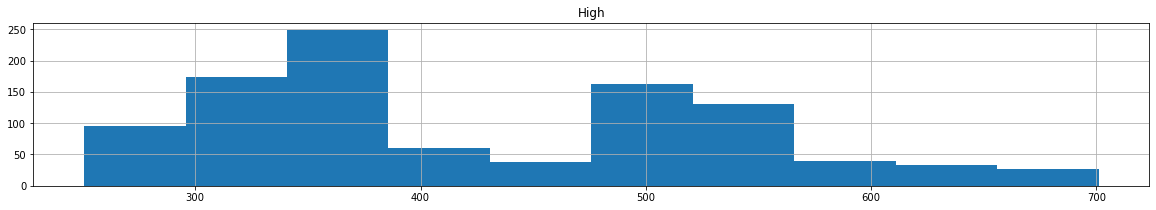

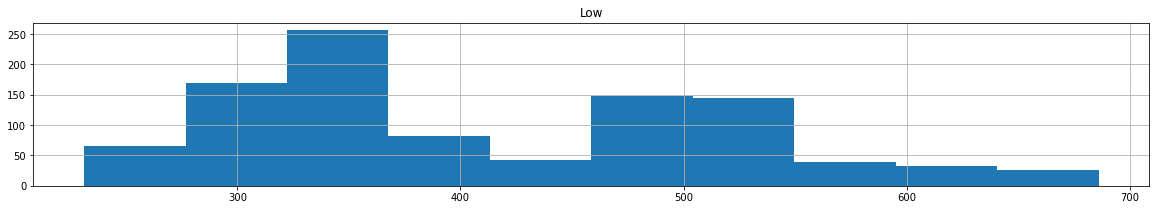

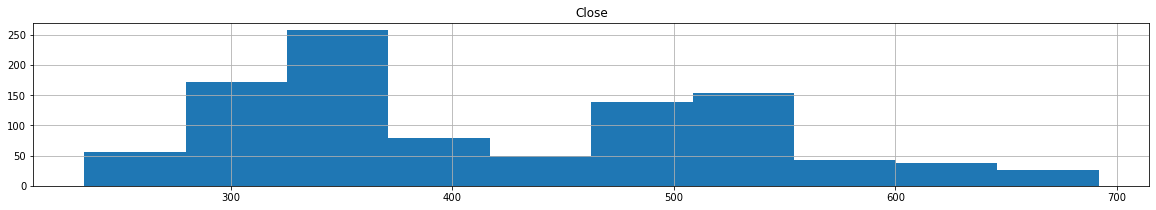

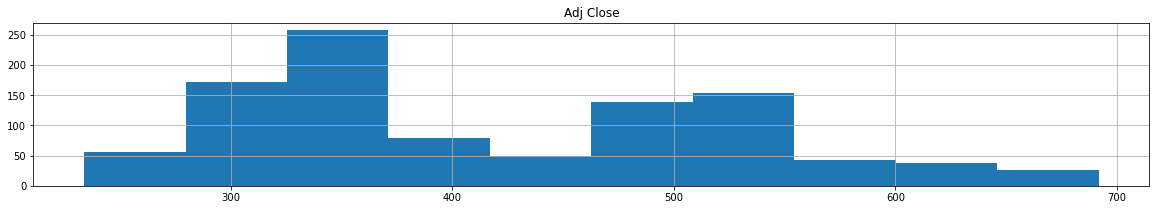

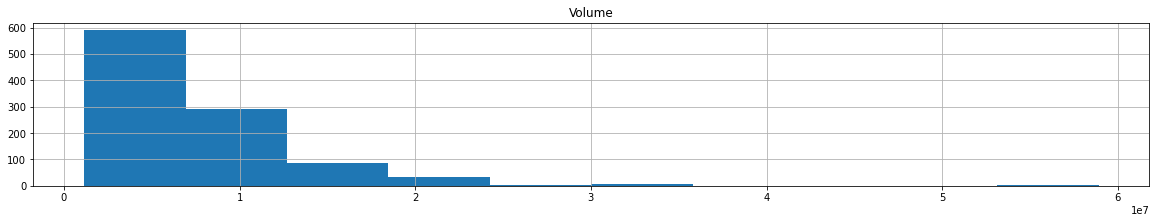

In [76]:
#iterate through all columns in netflix stock prices dataset
for column in netflix_stock_prices.columns:
    try:      
        netflix_stock_prices[column] = pd.to_numeric(netflix_stock_prices[column]) #convert column to numeric column
        netflix_stock_prices.hist(column) #if they are, display histogram
    except ValueError:
        print(f"The column {column} can not be represented as a histogram")

_[The second part of this brief data exploration is to figure out which features are categorical. The reason I need to do this is so that I can figure out which features to one-hot encode during the next phase(i.e. when we are preprocessing the data). This part of the analysis clearly shows that the features Open, High, Low, Close, Adj. Close, and Volume are not categorical variables because they don't take on a finite set of values. They can take on an infinite range of values. Hence, by definition, they cannot be considered categorical. The "Date" column is not really considered a variable here for the sake of analysis because its more so used to identify each data sample. Hence, I am not really considering it as a "variable" for analysis. Hence, given the aforementioned statements, it is clear that there are no categorical variables. ]_

Text(0.5, 1.0, 'Netflix Inc.')

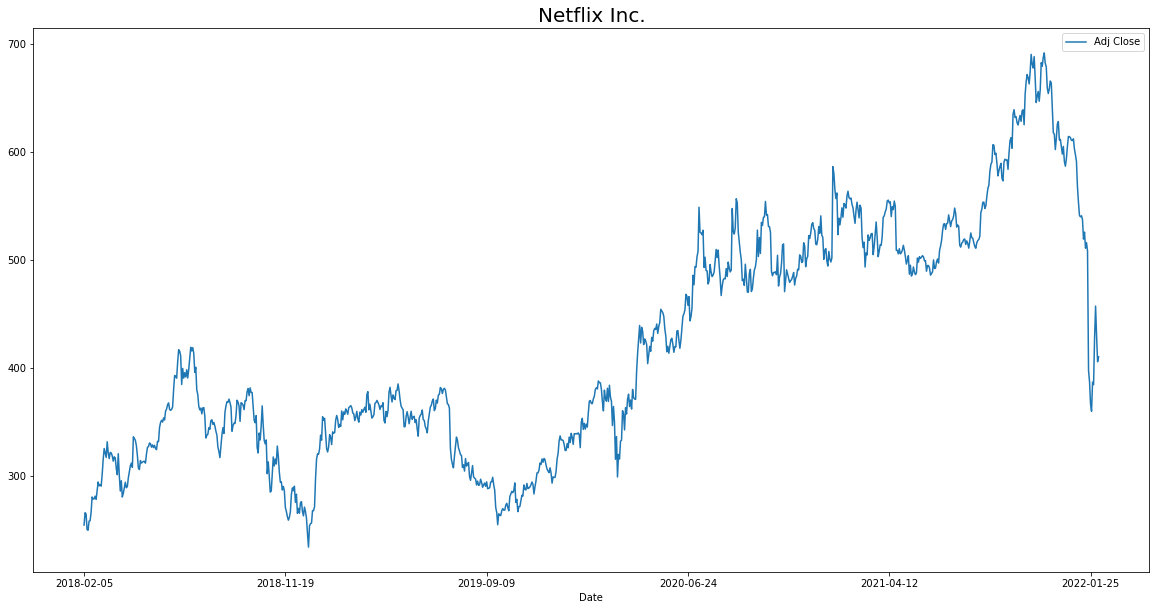

In [77]:
netflix_stock_prices.set_index("Date", inplace = True) #set date as the index
netflix_stock_prices[['Adj Close']].plot(figsize= (20, 10)) #Plot Stock Values for Netflix Over period from Feb 2018 to Feb 2022
plt.title("Netflix Inc.", fontsize = 20) #Title the Plot Netflix Inc. 

_[Since the Date variable is used to identify each data sample, I set the index of this dataframe to be the "Date" variable. I plotted the Adj.Close column of the dataframe on a graph to see the trends in Netflix Stock Price from Feb 2018 to Feb 2022. Clearly, we can see a general upwards trend over the past 5 years but quite few short-term fluctuations in the stock price. Another interesting thing to note is that, around January of 2022, there has been a sharp drop in the stock price of Netflix. This is, most probably, due to the fact that Netlix has been losing approximately 200,000 subscribers in the first three months of 2022 (i.e. first economic quarter)(Helmore 1). ]_

# **2. Pre-processing of Dataset**

In [78]:
#given the name of a feature and its corresponding value, return True if the value is logically valid for this feature
def is_logical(feature, value):
    #if value is np.nan or None, return false
    if (value == np.nan or value == None):
        return False
    
    #if feature is not Volume, return True if the value >= 125 and value <= 750
    if (feature != "Volume"):
        return value >= 125 and value <= 750
    
    #Else, we know the feature concerns the volume of the stock. Return true if the value >= 1 million and value <= 60 million
    return value >= 1000000 and value <= 60000000 

#iterate through all columns
for column in netflix_stock_prices:
    columnSeries = netflix_stock_prices[column] #retrieve column from data frame
    li = [] #list to store newly created column
    
    #Go through all values in the column. If the value is logically consistent, append this value to the list
    #If the value is not logically consistent, append NaN to the list
    for value in columnSeries:
        if (is_logical(column, value)):
            li.append(value)
        else:
            li.append(np.nan)
    
    #Convert li to pandas Series and store this in the column
    if (np.nan in li):
        netflix_stock_prices[column] = pd.Series(li, index = netflix_stock_prices.index)   

netflix_stock_prices.interpolate(inplace = True) #fill in NaN values via interpolation



_[After looking up the Netflix Stock Prices from Feb 2018 to Feb 2022, the lowest the stock price ever got to was roughly 175 and the highest it ever got to was 700. Hence, to set a reasonable buffer, I made the lower bound for price 125 and the higher bound 750. For volume, the lowest volume for stock prices from Feb 2018 to Feb 2022 was roughly 1.7 million and the highest was around 50 million. Hence, for a reasonable buffer, I set the lower bound for volume to be 1 million and the upper bound to be 60 million. Once I wrote the function to determine whether a value for particular feature is logically valid, I went through the dataframe to validate each and every value. Invalid values were simply repalced with NaN. After I finished validating values, I replaced any NaN values via simple interpolation. Essentially if there were NaN values between non-NaN values, the function interpolate() draws a line between the NaN values and replaces the NaN values with values on this line.  ]_

# **3. Feature Engineering / Feature Learning**

[98.89091439717556, 99.9715585267874, 99.99999844917598, 100.0, 100.0]


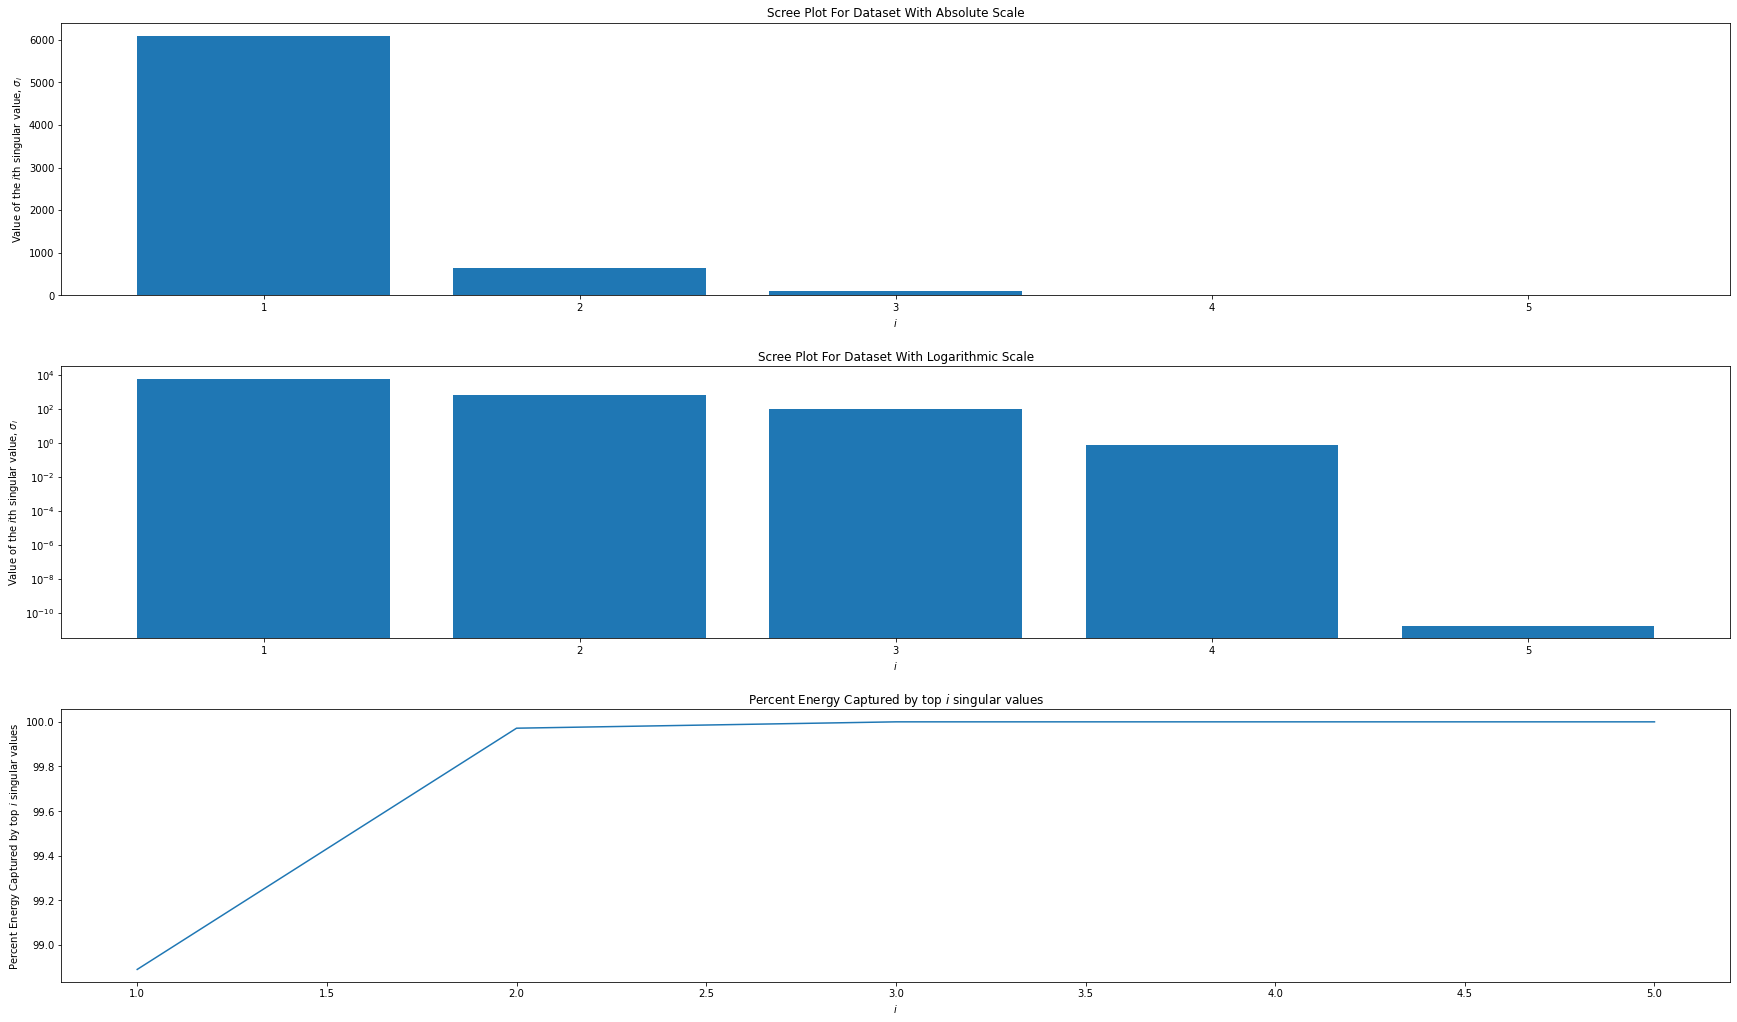

In [79]:
window_size = 10 #window of size 10
closing_prices = netflix_stock_prices["Adj Close"] #get closing prices 
moving_average = closing_prices.rolling(window = window_size, closed = "left").mean() #compute moving average over the past "window_size" days
standard_deviation = closing_prices.rolling(window = window_size, closed = "left").std() #compute standard deviation over the past "window_size" days
upper_band = moving_average + 2 * standard_deviation #compute upper band of bollinger band
lower_band = moving_average - 2 * standard_deviation #compute lower band of bollinger band
rate_of_change = closing_prices.pct_change().shift(1) #compute daily returns(i.e. rate of change)

exponential_moving_average = [np.nan for index in range(window_size)] #initialize array
exponential_moving_average.append(sum(closing_prices[:window_size]) / (window_size)) #calculate SMA of first window

#iterate through closing prices to compute EMA(Exponential Moving Average)
for index in range(window_size + 1, len(closing_prices)):
	closing_price = closing_prices[index - 1]  #closing price
	exponential_moving_average.append((closing_price * (2 / (1 + window_size))) + exponential_moving_average[-1] * (1 - (2 / (1 + window_size)))) #calculate EMA for next window and append it to array

netflix_stock_prices["Moving Average"] = moving_average #moving average
netflix_stock_prices["Upper Bollinger Band"] = upper_band #upper band
netflix_stock_prices["Lower Bollinger Band"] = lower_band #lower band
netflix_stock_prices["Exponential Moving Average"] = exponential_moving_average #Exponential Moving Average
netflix_stock_prices["Rate Of Change"] = rate_of_change #Rate of Change

X = netflix_stock_prices[["Moving Average", "Upper Bollinger Band", "Lower Bollinger Band", "Exponential Moving Average", "Rate Of Change"]].to_numpy() #Create X
X = X[window_size + 2: ] #Choose relevant data samples
Y = netflix_stock_prices[["Adj Close"]].to_numpy() #Create Y
Y = Y[window_size + 2: ] #Choose relevant labels

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=104, test_size=0.20, shuffle=True) #split data into remaining/test

# use the fit_transform API to simultaneously compute mean and center data
datascaler = sklpp.StandardScaler(with_mean = True, with_std = False) #initialize Standard Scaler object
X_train = datascaler.fit_transform(X_train) #fit it to training data and transform
X_test = datascaler.transform(X_test) #transform test data

#solve PCA problem
left_singular_vectors, singular_value_matrix, right_singular_vectors = np.linalg.svd(X_train)   #svd of centered matrix
total_energy = sum([singular_value * singular_value for singular_value in singular_value_matrix]) #total energy in centered dataset

cumulative_energy = 0   #initialize variable
k_values = [] #initialize array
percent_energy_captured = [] #initialize array
k = 0   #initialize k
for index in range(len(singular_value_matrix)):
    cumulative_energy = cumulative_energy + (singular_value_matrix[index] * singular_value_matrix[index])   #calculate energy of top k singular values
    k = k + 1   #increment k
    k_values.append(k) #append k to array
    percent_energy_captured.append((100 * cumulative_energy / total_energy)) #append percent energy captured cumulatively to the array

print(percent_energy_captured) #print percent_energy_captured

#Generate Scree Plot for dataset with absolute scale 
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize = (25, 15))
fig.tight_layout(pad=5.0)

ax1.set_title("Scree Plot For Dataset With Absolute Scale")
ax1.set_xlabel("$i$")
ax1.set_ylabel('Value of the $i$th singular value, $\sigma_i$')
ax1.bar(k_values, singular_value_matrix)

#Generate Scree Plot for dataset with logarithmic scale 
ax2.set_title("Scree Plot For Dataset With Logarithmic Scale")
ax2.set_xlabel("$i$")
ax2.set_ylabel('Value of the $i$th singular value, $\sigma_i$')
ax2.set_yscale("log")
ax2.bar(k_values, singular_value_matrix)


#Plot Percent Energy Captured
ax3.set_title("Percent Energy Captured by top $i$ singular values")
ax3.set_xlabel("$i$")
ax3.set_ylabel("Percent Energy Captured by top $i$ singular values")
ax3.plot(list(range(1, len(percent_energy_captured) + 1)), percent_energy_captured)


pca = skldecomp.PCA(n_components = 1, svd_solver = 'full')  #initialize PCA object with 1 components
X_train = pca.fit_transform(X_train) #map remaining data points onto PCA subspace
X_test = pca.transform(X_test) #map test data points onto same PCA subspace



Analysis of Feature Engineering/Learning: 

Bollinger Bands: 

What are Bollinger Bands? 

Bollinger Bands consists of three bands(i.e. a middle band, an upper band, and a lower band). The middle band is essentially a moving average of the stock price. The upper and lower bands lie above/below the middle band by a certain number of standard deviations. For the purpose of this machine learning mode, I chose the standard deviation to be 2 since this is the standard deviation that is most commonly chosen(Hayes 1). Bollinger bands are commonly used by stock traders to evaluate a stock’s volatility(“Bollinger Bands: What They Are and How to Use Them"). Usually, traders compare a stock’s price relative to the Bollinger bands(“Bollinger Bands: What They Are and How to Use Them"). If the stock price is closer to the upper band, then it can be shown that the stock’s price is relatively high. On the other hand, if the stock’s price is closer to the lower band, then it can be shown that the stock’s price is relatively low. Another piece of information we can glean from the Bollinger Band is that the width of the Bollinger Band(i.e. spread across the lower to upper band) is an indicator of a stock’s volatility(“Bollinger Bands: What They Are and How to Use Them"). This makes perfect sense. A Bollinger Band that has a larger spread(i.e. larger distance between upper and lower band) indicates a stock price that fluctuates quite a lot. On the other hand, a Bollinger Band that has a smaller spread(i.e. smaller distance between upper and lower band) indicates a stock price that doesn’t fluctuate that much. 

As shown by the above discussion, since Bollinger Bands are a good indication of a stock’s volatility, I included the Moving Average, Upper Band, and Lower Band(i.e. the three components of a Bollinger Band) as features for my Machine Learning Model 

Exponential Moving Average: 

What is the Exponential Moving Average? 

This term sounds quite similar to Moving Average(i.e. the middle band of the Bollinger Band). However, there is an important distinction that we should discuss. Moving Average(i.e. often referred to as Simple Moving Average) simply takes the average of the stock price over a certain period. Exponential Moving Average(EMA) is very similar in that it strives to capture the trend direction of the stock over a period of time("What Is Ema?- Exponential Moving Average"). However,  the key distinction is that EMA computes a weighted average and, in the process, assigns higher weights to stock prices that occur more recently. This way, EMA is more sensitive to price movement and tend to identify trends in stock prices earlier than regular Moving Averages do("What Is Ema?- Exponential Moving Average"). 

The formual to calculate EMA is EMA = Closing price x multiplier + EMA (previous day) x (1-multiplier) where the multiplier is commonly taken to be 2(Chen  1). 

As shown by the above discussion, since Exponential Moving Averages are more sensitive to price movements and can identify stock price trends earlier than regular Moving Averages,  I felt that EMA(Exponential Moving Average) is a good indicator of trend direction. Hence, I chose to include Exponential Moving Averages as one of my features in the Machine Learning model. 

Rate of Change: 

What is the Rate of Change?

Rate of Change is the daily gain/loss posted by a stock. Securities with “high momentum, or one that has a positive ROC, normally outperforms the market in the short term. Conversely, a security that has a ROC that falls below its moving average, or one that has a low or negative ROC is likely to decline in value and can be seen as a sell signal to investors”"Rate of Change Definition, Formula, and Importance")


How was the window over which to calculate the Moving Averages Selected?
Due to the fact that 5, 10, 20, and 50 day moving averages are often used to spot short term trend changes in stocks(Maverick 1), I decided to simply use the 10 day window for my moving average calculations. 
 

Why was PCA used on the data matrix? 

In order to determine whether PCA was needed on my data matrix, I calculated the SVD of my data matrix X. As we learned during our studies of PCA, the singular values of X are the square root of the eigenvalues of $X^TX$. Hence, we can analyze the singular values of X to determine what percentage of the total energy is captured by the top K eigenvalues of $X^TX$. As shown by graph, the top 1 eigenvalues capture roughly 99 percent of the total energy in the dataset.  Hence, we can take the data from the original 5 dimensional space and map it to a 1 dimensional subspace within this 5 dimensional space. Since we will be capturing roughly 99 percent of the total energy in the dataset, the projected data samples will still retain almost all of the original variation from the dataset that was present in 5 dimensions. Hence, this is why I conducted PCA with the number of components being 1 


Prior to applying PCA, I mean centered the data as we learned during the lectures. 

Explanations of scikit learn functions I used in this part of the project: 
train_test_split: Split a batch of data into training and test data. 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=104, test_size=0.20, shuffle=True) split data into remaining/test

This line takes the data(i.e. features are in X and labels are in Y) and creates X_test(features for test data), Y_test(labels for test data). test_size = 0.20 means that this method takes 20 percent of the original data and sets it aside as test data. shuffle = True means that this function shuffles the data before splitting into train/test to avoid being too deterministic in its split 

Other parameters for train_test_split include train_size(specifies how big training split should be), random_state(controls shuffling of data), stratify(stratified split essentially makes data of different labels occur in roughly equal portions in the training/test/validation data set)

StandardScaler(), fit_transform, transform: 

this is responsible for centering the data. fit_transform() will fit to the data and then center the data
transform will center the data based on the mean already computed by fit_transform()

skldecomp.PCA(), fit_transform, transform, inverse_transform(): 
PCA() is responsible for doing PCA()

fit_transform() will fit to the data and project the points onto a PCA subspace of minimal projection error 
transform will project the points onto a PCA subspace already determined by fit_transform 
inverse_transform takes the data points on the PCA subspace and represented them in the original dimension

# **4. Processing The Dataset Via Machine Learning**

In [80]:
alphas_model1 = np.linspace(0.1, 1000, 10000, endpoint = False) #create alphas for Ridge Regression cross validation testing

cross_validation_scores_model1 = [cross_validate(Ridge(alpha), X_train, Y_train) for alpha in alphas_model1] #compute cross validation scores for each alpha for Ridge Regression
mean_validation_scores_model1 = [data["test_score"].mean() for data in cross_validation_scores_model1] #compute mean of cross validation scores
std_validation_scores_model1 = [data["test_score"].std() for data in cross_validation_scores_model1] #compute standard deviation of cross validation scores
best_alpha_model1 = alphas_model1[np.argmax(mean_validation_scores_model1)] #determine which alphs gives us best cross validation score

print(f"Best Value of Alpha for Ridge Regression: {best_alpha_model1}") #print statement

alphas_model2 = np.linspace(0.1, 1000, 10000, endpoint = False)  #create alphas for Lasso Regression cross validation testing
cross_validation_scores_model2 = [cross_validate(Lasso(alpha), X_train, Y_train) for alpha in alphas_model2] #compute cross validation scores for each alpha for Lasso Regression
mean_validation_scores_model2 = [data["test_score"].mean() for data in cross_validation_scores_model2] #compute mean of cross validation scores
std_validation_scores_model2 = [data["test_score"].std() for data in cross_validation_scores_model2] #compute standard deviation of cross validation scores
best_alpha_model2 = alphas_model2[np.argmax(mean_validation_scores_model2)] #determine which alphs gives us best cross validation score

print(f"Best Value of Alpha for Lasso Regression: {best_alpha_model2}") #print statement 

Best Value of Alpha for Ridge Regression: 999.90001
Best Value of Alpha for Lasso Regression: 27.59725


In this section of the project, the requirement is to "process the dataset using two different machine learning methods". Given that my task here is to predict the price of NFLX Stock using regression methods, the machine learning methods I have chosen is Ridge and Lasso Regression.

Let's do the analysis for Ridge and Lasso Regression. In Ridge Regression, we are trying to solve the following equation: 
$$\beta = \underset{\beta \in \mathbb{R}^{p + 1}}{\operatorname{argmin}} \enspace ||Y - X \beta||_2^2 + \lambda ||\beta||_2^2$$

The solution to this Ridge Regression Equation is: 
$$ (X^TX + \lambda I)^{-1} X^T Y$$

Similarly, for Lasso Regression, the equation is 
$$\beta = \underset{\beta \in \mathbb{R}^{p + 1}}{\operatorname{argmin}} \enspace ||Y - X \beta||_2^2 + \lambda ||\beta||_1$$

However, this begs the question as to what do we make $\lambda$

I wanted to test $\lambda$ values from 0.1 to 1000 since, if I make it too big, the term $\lambda ||\beta||_2^2$(i.e. for Ridge Regression) or $\lambda ||\beta||_1$(i.e. for Lasso Regression) begins to dominate the aforementioned equations. 


As we learned in class, whenever we have such parameters, the best approach is to do cross validation. I will explain the overall procedure I followed for Cross Validation: 

Note: In Section 3, I used scikit-learn's function to take the original dataset and split it into X_train, X_test, Y_train, and Y_test. X_test(i.e. features for test data) and Y_test(i.e. labels for test data) is the test data that will be used in section 5 to report the performance of the model on "unseen data". Hence, it will be used to indicate the model's generalization error. Hence, X_test and Y_test will be untouched for this section. 

Given that I have X_train and Y_train(i.e. remaining features/labels once the test data has already been extracted and aside), I will be using X_train and Y_train to run K-Fold Cross Validation 

As per the project instructions, the team was given explicit permission to use scikit-learn. To perform K-Fold cross validation, I used the scikit-learn function "cross_validate". Let me explain, in detail, what this function does. 

The list of parameters for this function are as follows: 
estimator: This is basically the model that we are performing cross validation for. In my case, it is the Ridge model(i.e. represents Ridge Regression) and Lasso(i.e. represents Lasso Regression). I will elaborate more on the Ridge and Lasso constructors from sklearn later onwards 
X: array of features(i.e. features for each sample should be on each row of this matrix)
Y: array of labels(i.e. each row is the label for the corresponding data sample in the same row of X)
groups: specify groups(i.e. classes) such that these groups are not split across training/test sets during cross validation. Not applicable for this case
scoring: Scoring strategy to evaluate model while doing cross validation(e.g. R2 Score for Linear Regression Models)
cv: Used to modify cross validation splitting strategy. If we pass in no value for cv, the default 5 fold cross validation is use. We can also pass in a number indicating the number of folds we would like to perform. We can also pass in a CV Splitter to specialize the way we would like to split our data during cross validation. Finally, we can also pass in an iterator that gives us (train, test) splits as such. 
n_jobs: Number of jobs to run in parallel. This enables us to parallelize all the iterations of training the model and computing the scores. Setting this parameter to None just means we will be running only 1 job in parallel(i.e. essentially sequentially)
verbose: Determines how we want to print progress messages as we are performing K-Fold Cross Validation. Default is 0(i.e. print no progress messages)
fit_params: parameters with which we call fit() for the model
pre_dispatch: number of jobs that we dispatch during parallel execution
return_train_score: If set to true, return the training scores computed during K-Fold Cross Validation. Default is False
return_estimator: If set to true, return the models fitted during each iteration of K-Fold Cross Validation. Default is False
error_score: Denotes what score to assign when there is an error in training the model. Default is np.nan(i.e. Not a Number)

Returns: training_scores(if return_train_score = True), test_scores(i.e. test scores computed during K-Fold Cross Validation), fit_time(i.e. time needed to train model during each split), score_time(i.e. time taken to compute score during each split), estimator(if return_estimator = True, we return the estimator fitted during each split)


Hence, in my code, I set the parameter "estimator" to Ridge(alpha) meaning I want to use a Ridge Regression estimator with the $\lambda = alpha$
I set the parameter "X" equal to X_train and "Y" equal to Y_train since I wanted to use all the data(i.e. except for test data) as data for cross validation

The rest of the variables I set to the default options since I wanted to run 5 Fold Cross Validation

Discussion about Ridge(alpha):
Creates Ridge Regression model with $\lambda = alpha$

other parameters for Ridge():
fit_intercept, default is True
True if we want our linear regression model to have an intercept. False, if we don't need intercept(i.e. data is already centered) 

copy_X, default=True
If we don't want X to be overwritten set this parameter to True. Else, it may be overwritten

max_iterint, default=None
"Maximum number of iterations for conjugate gradient solver. For ‘sparse_cg’ and ‘lsqr’ solvers, the default value is determined by scipy.sparse.linalg. For ‘sag’ solver, the default value is 1000. For ‘lbfgs’ solver, the default value is 15000"

tolfloat, default = 1e-4
Indicates how precise we want our solution to be

I set fit_intercept to its default value of True. I did run the PCA Algorithm in section 3 so we know that our transformed data points lie on a 2 dimensional subspace in our original 5 dimensional space. However, we have no guarantee that these points are centered on this subspace. Hence, to be safe, I just set fit_intercept to its default value of True 


I let copy_X be true(default value) just in case I need to use X again
I left max_iterint to be at its default value to let the gradient solver use as many iterations as it needs
I left the tolfloat parameter to be its default because there was no need to change it 


Discussion about Lasso(alpha):
Creates Lasso Regression model with $\lambda = alpha$

other parameters for Lasso():
fit_intercept, default is True
True if we want our linear regression model to have an intercept. False, if we don't need intercept(i.e. data is already centered) 

copy_X, default=True
If we don't want X to be overwritten set this parameter to True. Else, it may be overwritten

max_iterint, default=None
"Maximum number of iterations for conjugate gradient solver. For ‘sparse_cg’ and ‘lsqr’ solvers, the default value is determined by scipy.sparse.linalg. For ‘sag’ solver, the default value is 1000. For ‘lbfgs’ solver, the default value is 15000"

tolfloat, default = 1e-4
Indicates how precise we want our solution to be

I set fit_intercept to its default value of True. I did run the PCA Algorithm in section 3 so we know that our transformed data points lie on a 2 dimensional subspace in our original 5 dimensional space. However, we have no guarantee that these points are centered on this subspace. Hence, to be safe, I just set fit_intercept to its default value of True 


I let copy_X be true(default value) just in case I need to use X again
I left max_iterint to be at its default value to let the gradient solver use as many iterations as it needs
I left the tolfloat parameter to be its default because there was no need to change it 


This is how I ran K Fold Cross validation for both my Ridge and Lasso Regression Models. 

How did I choose the best alpha to select? 
I chose the best alpha as follows. Essentially, for each alpha, I took the mean of the cross validation scores across all the splits. I chose the value fo alpha that gave me the lowest cross validation mean score. 

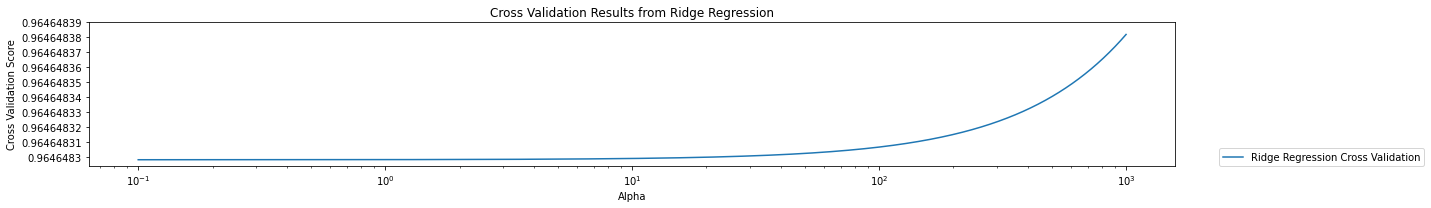

In [81]:
#Plot Cross Validation results from Ridge Regression
plt.rcParams["figure.figsize"] = (20,3)
plt.title("Cross Validation Results from Ridge Regression")
plt.plot(alphas_model1, mean_validation_scores_model1, label= "Ridge Regression Cross Validation")
#plt.errorbar(alphas_model1, mean_validation_scores_model1, std_validation_scores_model1, fmt = "o")
plt.legend(loc = (1.04, 0))
plt.yticks([0.9646483, 0.96464831,  0.96464832, 0.96464833, 0.96464834, 0.96464835, 0.96464836, 0.96464837, 0.96464838,0.96464839], [0.9646483, 0.96464831,  0.96464832, 0.96464833, 0.96464834, 0.96464835, 0.96464836, 0.96464837, 0.96464838,0.96464839])
plt.xscale("log")
plt.xlabel('Alpha')
plt.ylabel('Cross Validation Score')
plt.tight_layout()
plt.show()


In this section, I am plotting the cross validation results for Ridge Regression. Clearly, the cross validation score is best when the alpha parameter was roughly 1000.

In [82]:
start = time.time() #start time that we are beginning our training for Ridge Regression
model1 = Ridge(best_alpha_model1).fit(X_train, Y_train) #fit a Linear Regression(i.e. Ridge Regression) model to the data
end = time.time() #end time for training for Ridge Regression

print("Time Elapsed to train Ridge Regression: ", end - start) #print time elapsed for training ridge regression

prediction = model1.predict(X_train) #make prediction for training data
r_squared_score = r2_score(Y_train, prediction) #calculate R^2 statistic for ridge regression model over training data
print("R Squared Score for Training Data: ", r_squared_score) #print R^2 score for training for ridge regression




Time Elapsed to train Ridge Regression:  0.001291036605834961
R Squared Score for Training Data:  0.965084081418372


Furthermore, I am training a Ridge Regression Model based on the $\lambda$ parameter that I found to be best during cross validation. the fit(X, Y) function literally fits a Ridge Regression model where X is the training data and Y is the training labels. 

In this section, I am determining the time taken to train the Ridge Regression Model. Furthemore, I am also determining the $R^{2}$ score for the Ridge Regression Model on the training data. The $R^{2}$  for Training Data is roughly 0.965, meaning that the linear regression model can capture most of the variation in the training data. 

The predict() function takes a dataset and returns the model's predictions for each data sample in the dataset. 

The r2_score() function takes the expected labels and the predictions and computes $R^{2}$ score

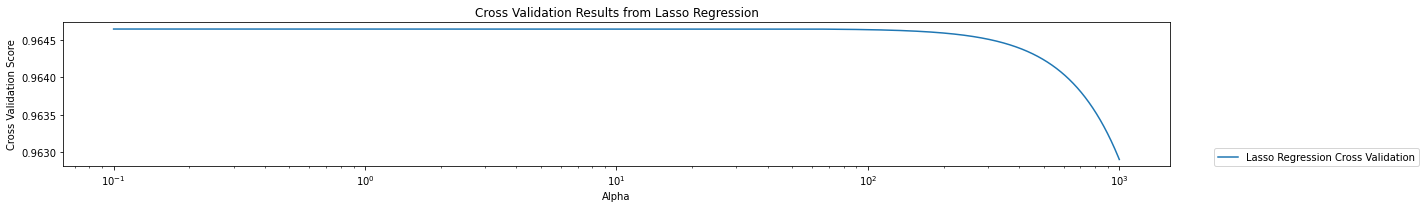

In [83]:
#Plot Cross Validation results from Lasso Regression
plt.rcParams["figure.figsize"] = (20,3)
plt.title("Cross Validation Results from Lasso Regression")
plt.plot(alphas_model2, mean_validation_scores_model2, label= "Lasso Regression Cross Validation")
#plt.errorbar(alphas_model2, mean_validation_scores_model2, std_validation_scores_model2, fmt = "o")
plt.legend(loc = (1.04, 0))
plt.xscale("log")
plt.xlabel('Alpha')
plt.ylabel('Cross Validation Score')
plt.tight_layout()
plt.show()


In this section, I am plotting the cross validation results for Lasso Regression. Clearly, the cross validation score is best when the alpha parameter was roughly 28.

In [84]:
start = time.time() #start time that we are beginning our training for Lasso Regression
model2 = Lasso(best_alpha_model2).fit(X_train, Y_train) #fit a Linear Regression(i.e. Lasso Regression) model to the data
end = time.time() #print end time for training for Lasso Regression
print("Time Elapsed to Train Lasso Regression Model: ", end - start) #print time elapsed to train lasso regression model

prediction = model2.predict(X_train) #make prediction for training data
r_squared_score = r2_score(Y_train, prediction) #calculate R^2 statistic for lasso regression model over training data
print("R Squared Score for Training Data: ", r_squared_score) #print R^2 score for lasso regression over training data



Time Elapsed to Train Lasso Regression Model:  0.0009570121765136719
R Squared Score for Training Data:  0.9650826808280353


In this section, I am determining the time taken to train the Lasso Regression Model. Furthemore, I am also determining the $R^{2}$ score for the Lasso Regression Model on the training data. 

Furthermore, I am training a Lasso Regression Model based on the $\lambda$ parameter that I found to be best during cross validation. the fit(X, Y) function literally fits a Lasso Regression model where X is the training data and Y is the training labels. 

In this section, I am determining the time taken to train the Lasso Regression Model. Furthemore, I am also determining the $R^{2}$ score for the Lasso Regression Model on the training data. The $R^{2}$  for Training Data is roughly 0.965, meaning that the linear regression model can capture most of the variation in the training data. 

The predict() function takes a dataset and returns the model's predictions for each data sample in the dataset. 

The r2_score() function takes the expected labels and the predictions and computes $R^{2}$ score

Note: The time taken to train Ridge Regression(roughly 0.0012 seconds) is slightly larger than the time taken to train Lasso Regression(roughly 0.000957 seconds). 

# **5. Comparative Analysis**

In [85]:
future_stock_prices = pd.read_csv("NFLX_Future.csv") #get CSV file with future NFLX prices. This allows me to assess my model's performance
future_stock_prices.set_index("Date", inplace = True) #set index to be the "Date" column
future_stock_prices = future_stock_prices.loc[netflix_stock_prices.index[-1]: ] #pick stock prices for the future(i.e. date where the other csv ends)

N, P = X_test.shape #calculate number of rowx in test dataset
start = time.time() #start time
prediction = model1.predict(X_test) #make prediction for test data
end = time.time() #end time
print("Time Taken to Test Ridge Regression Model: ", end - start)
r_squared_score = r2_score(Y_test, prediction) #calculate R^2 test statistic for ridge regression model
print(f"R2 Test Statistic for Ridge Regression Model: {r_squared_score}") #print  R^2 test statistic for ridge regression model

num_rows = len(future_stock_prices) #number of future predictions we want to make
exponential_moving_average = exponential_moving_average[(-1 * window_size): ] #keep window of exponential moving averages
closing_prices = closing_prices.to_list() #store closing prices in array
closing_prices = closing_prices[(-1 * window_size): ] #keep window of closing prices
feature_array = np.zeros((1, 5)) #initialize feature array
forecasts = np.zeros((num_rows + 1, 1)) #initialize array of forecasts
forecasts[0] = np.array([closing_prices[-1]]) #keep initial value of forecast as final stock closing price in netflix stock price dataframe

#Iterate through num_rows
for day in range(num_rows):
    avg_price = np.mean(closing_prices) #calculate average price of closing prices(moving average)
    std_price = np.std(closing_prices) #calculate standard deviation of price of closing prices(standard dev)
    ema =  2 * (closing_prices[-1] - exponential_moving_average[-1]) + exponential_moving_average[-1] #calculate Exponential Moving Average
    feature_array[0][0] = avg_price #store avg price in feature array
    feature_array[0][1] = avg_price + 2 * std_price #store upper band of bollinger curve in feature array
    feature_array[0][2] = avg_price - 2 * std_price #store lower band of bollinger curve in feature array
    feature_array[0][3] = ema #store ema in feature array
    feature_array[0][4] = (closing_prices[-1] - closing_prices[-2]) / (closing_prices[-2]) #store Rate of Change in feature array
        
    transformed_feature_array = datascaler.transform(feature_array) #center data
    transformed_feature_array = pca.transform(transformed_feature_array) #project data onto our PCA subspace
    forecasted_price = model1.predict(transformed_feature_array) #Get a prediction from Ridge Regression model
    forecasted_price = forecasted_price[0][0] #get forecasted price
    forecasts[day + 1][0] = forecasted_price #store price in forecasts array
    exponential_moving_average = exponential_moving_average[1: ] #get all exponential moving averages except first one
    exponential_moving_average.append(ema) #append newly calculated EMA(Expoenential Moving Average)
    closing_prices = closing_prices[1: ] #get all closing prices except first one
    closing_prices.append(forecasted_price) #append newly forecasted price
    
#put forecasted predictions in dataframe
future_stock_predictions_model1 = pd.DataFrame({"Forecasts": forecasts.flatten()}, index=pd.date_range(start= netflix_stock_prices.index[-1], periods=len(forecasts), freq="B", inclusive = "both").format(formatter=lambda x: x.strftime('%Y-%m-%d')))


Time Taken to Test Ridge Regression Model:  0.00025010108947753906
R2 Test Statistic for Ridge Regression Model: 0.9697256641959395


Just for reference, the csv file "NFLX_Future" is a csv file with stock prices from February 2022 to June 2022. This date range is not included in NFLX.csv. So basically, I train my models on the data given to me in NFLX.csv, then I use that model to forecast stock prices from February 2022 to June 2022. I use the data in NFLX_Future to see how accurate my predictions are. The above code cell is responsible for computing forecasts using the Ridge Regression model. 

Explanation of scikit learn functions used in this code snippet: 

model.predict(X_test): This function basically takes our model(i.e. either a Ridge or Lasso Regression model) and generates outputs for each sample in our test data. The outputs are returned nicely in a vector for us to have

r2_score(Y_test, predictions): Given the ground truth data(i.e. Y_test) and the predictions from our model(i.e. predictions), this function allows me to assess the performance of my regression models by computing the $\mathbb{R}^2$ score. 

In [86]:
N, P = X_test.shape #calculate number of rowx in test dataset
start = time.time()
prediction = model2.predict(X_test) #make prediction for test data
end = time.time() 
print("Time Taken to Test Lasso Regression Model: ", end - start)
r_squared_score = r2_score(Y_test, prediction) #calculate R^2 test statistic for lasso regression model
print(f"R2 Test Statistic for Lasso Regression: {r_squared_score}") #print  R^2 test statistic for lasso regression model

num_rows = len(future_stock_prices) #number of future predictions we want to make
exponential_moving_average = netflix_stock_prices["Exponential Moving Average"] #get exponential moving averages
exponential_moving_average = exponential_moving_average.to_list() #convert to list
exponential_moving_average = exponential_moving_average[(-1 * window_size): ] #keep window of exponential moving averages
closing_prices = netflix_stock_prices["Adj Close"] #get closing prices 
closing_prices = closing_prices.to_list() #store closing prices in array
closing_prices = closing_prices[(-1 * window_size): ] #keep window of closing prices
feature_array = np.zeros((1, 5)) #initialize feature array
forecasts = np.zeros((num_rows + 1, 1)) #initialize array of forecasts
forecasts[0] = np.array([closing_prices[-1]]) #keep initial value of forecast as final stock closing price in netflix stock price dataframe

#Iterate through num_rows
for day in range(num_rows):
    avg_price = np.mean(closing_prices) #calculate average price of closing prices(moving average)
    std_price = np.std(closing_prices) #calculate standard deviation of price of closing prices(standard dev)
    ema =  2 * (closing_prices[-1] - exponential_moving_average[-1]) + exponential_moving_average[-1] #calculate Exponential Moving Average
    feature_array[0][0] = avg_price #store avg price in feature array
    feature_array[0][1] = avg_price + 2 * std_price #store upper band of bollinger curve in feature array
    feature_array[0][2] = avg_price - 2 * std_price #store lower band of bollinger curve in feature array
    feature_array[0][3] = ema #store ema in feature array
    feature_array[0][4] = (closing_prices[-1] - closing_prices[-2]) / (closing_prices[-2]) #store Rate of Change in feature array
        
    transformed_feature_array = datascaler.transform(feature_array) #center data
    transformed_feature_array = pca.transform(transformed_feature_array) #project data onto our PCA subspace
    forecasted_price = model2.predict(transformed_feature_array)  #Get a prediction from Lasso Regression model
    forecasted_price = forecasted_price[0] #get forecasted price
    forecasts[day + 1][0] = forecasted_price #store price in forecasts array
    exponential_moving_average = exponential_moving_average[1: ] #get all exponential moving averages except first one
    exponential_moving_average.append(ema) #append newly calculated EMA(Expoenential Moving Average)
    closing_prices = closing_prices[1: ] #get all closing prices except first one
    closing_prices.append(forecasted_price) #append newly forecasted price
    
#put forecasted predictions in dataframe
future_stock_predictions_model2 = pd.DataFrame({"Forecasts": forecasts.flatten()}, index=pd.date_range(start= netflix_stock_prices.index[-1], periods=len(forecasts), freq="B", inclusive = "both").format(formatter=lambda x: x.strftime('%Y-%m-%d')))


Time Taken to Test Lasso Regression Model:  0.00024819374084472656
R2 Test Statistic for Lasso Regression: 0.9696722870104546


Just for reference, the csv file "NFLX_Future" is a csv file with stock prices from February 2022 to June 2022. This date range is not included in NFLX.csv. So basically, I train my models on the data given to me in NFLX.csv, then I use that model to forecast stock prices from February 2022 to June 2022. I use the data in NFLX_Future to see how accurate my predictions are. The above code cell is responsible for computing forecasts using the Lasso Regression model. 


Explanation of scikit learn functions used in this code snippet: 

model.predict(X_test): This function basically takes our model(i.e. either a Ridge or Lasso Regression model) and generates outputs for each sample in our test data. The outputs are returned nicely in a vector for us to have

r2_score(Y_test, predictions): Given the ground truth data(i.e. Y_test) and the predictions from our model(i.e. predictions), this function allows me to assess the performance of my regression models by computing the $\mathbb{R}^2$ score. 

Comparison of Computational Complexity Between Both Lasso and Ridge Regression: 
As we can see, the time taken to run the fitted Lasso and Ridge Regression Models on the test data is approximately the same. The time taken to train the Lasso Regression model is approximately the same as the time taken to train the Ridge Regression Model. 

Comparison of Performance Between Lasso and Ridge Regression: 
To analyze the performance of Lasso and Ridge Regression, I will first analyze how the models performed on the test data portion from my original dataset. Then, I will, for exploratory purposes, analyze how our model did on future prices that were beyond our original dataset. 

How did the models perform on test data? 
As shown in earlier code cells, to gauge the regression models, I used the R^2 test statistic. As we covered in lecture, the R^2 test statistic is calculated by the following formula: 
$$R^{2} = 1 - \frac{\sum_{i=1}^n (y_{i} - f(x_{i}))^2}{\sum_{i=1}^n (y_{i} - \hat{y})^2}$$

A brief explanation of notation. $\hat{y}$ refers to the mean of all the labels of our data sample. Each data sample is represented as ($(x_{i}, y_{i})$) where $x_{i}$ is the features and $y_{i}$ is the label. $f(x_{i})$ is the output of the regression model once we put the feature into the regression model. 

$\sum_{i=1}^n (y_{i} - f(x_{i}))^2$ is the Residual Sum of Squares and $\sum_{i=1}^n (y_{i} - \hat{y})^2$ is the Total Sum of Squares. 


What are we looking for with this test statistic? 

Well, as we stated in lecture, a higher $R^{2}$ indicates that our model is a better predictor. A $R^{2}$ value of 1 indicates that our model is essentially perfect because this would mean that our model predicts all the labels in our test dataset 100 percent accurately. On the other hand, a $R^{2}$ value of 0 means that our model is performing no better than a constant model(i.e. a model that just outputs the mean of the labels of the data samples). 

Explanation of test statistics that I observed: 

The $R^{2}$ value for the Ridge Regression and Lasso Regression model are both approximately 0.9697. Hence, this indicates to me that the performance of both the Ridge Regression and Lasso Regression are roughly the same. Both Lasso and Ridge Regression were able to produce Regression models that capture almost all of the variation in the labels of the original dataset(i.e. the adjusted closing price of the Netflix Stock). 

Which model should we send into production?

Due to the fact that the $R^{2}$ values are roughly similar across Ridge and Lasso Regression, we will turn to computational complexity analysis and, since Ridge Regression takes more time to train on our training dataset, we recommend that Lasso Regression be put into production. For larger datasets, where training time could prove to be an issue, it is expected that Lasso Regression will train faster based on the experimental results obtained here. 

The time taken to test both Ridge and Lasso Regression models is almost identical due to the fact that they have the same model structure(i.e. both are forms of linear regression models). Hence, it is expected that the time taken to test these models should be almost identical. 


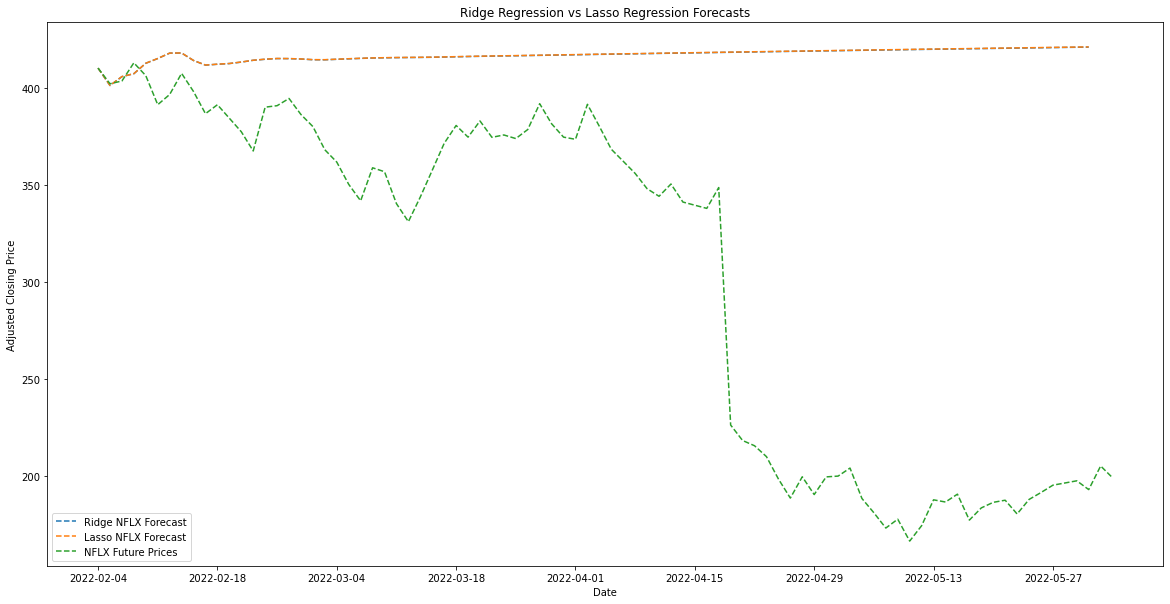

In [87]:
plt.rcParams["figure.figsize"] = (20,10) #set figure size

fig, ax = plt.subplots() #create subplots
ax.set_title("Ridge Regression vs Lasso Regression Forecasts") #set title of plot
ax.set_xlabel("Date") #set x label of plot
ax.set_ylabel("Adjusted Closing Price") #set y label of plot

ax.plot(future_stock_predictions_model1["Forecasts"], linestyle='dashed', label = "Ridge NFLX Forecast") #plot Ridge Regression Forecasts
ax.plot(future_stock_predictions_model2["Forecasts"], linestyle='dashed', label = "Lasso NFLX Forecast") #Plot Lasso Regression Forecasts
ax.plot(future_stock_prices['Adj Close'], linestyle='dashed', label = "NFLX Future Prices") #plot Actual Prices during the Forecast period obtained from Kaggle
ax.xaxis.set_major_locator(mticker.IndexLocator( base = 10, offset = 0)) #Set Ticks
ax.legend() #Set axis legend

plt.show() #show plot


For fun, I decided to use my Lasso and Ridge Regression models to forecast the NFLX Stock price for dates that are outside the date range in my original CSV File. So basically, "NFLX.csv" contains the price of NFLX Stock from February 2018 to February 2022. The csv file "NFLX_Future.csv" contains NFLX stock data from May 2002 to June 2022. I used the portion of the csv file "NFLX_Future.csv" that corresponded to NFLX Data from February 2022 to June 2022 in order to validate my forecasts from the Ridge and Lasso Regression models. As shown by the graphs, my forecasts from Ridge and Lasso regression did not perform too well. However, the reason I believe my model did not perform too well is that Netflix recently suffered from an unprecedented drop in subscriber count. Netflix lost almost 1 million subscribers from April through June 2022(Solsman 1). This subscriber drop was the biggest loss in Netflix's subscriber base that it has ever reported. This subscriber drop would've caused the stock price of Netflix to take several dips. Since this subscriber drop of this magnitude has never really happened before in Netflix's history, there would not have been such a significant drop off in Netflix's stock price during the entire range of the time series data(i.e. Netflix's stock price data). Hence, since this kind of loss in subscribers and the ensuing drop in Netflix's stock price is unprecedented, our Machine Learning model would not have been able to learn that from the training data itself. Hence, this explains why my Machine Learning models were not able to foresee this large dropoff in Netflix's stock price.  

# **6. Discussion of Ethical Issues**

In recent years, the predictive capabilities of Machine Learning models have transformed the financial industry. In an attempt to make more prudent investment decisions, Many quantitative trading firms have begun adopting ML models to make stock price forecasts. However, it is essential that the ethical component of using ML-based system in stock forecasting is carefully evaluated, especially due to the rise of stock fraud, Ponzi Schemes, Insider Trading, etc in recent years. 

To begin the disussion on ethical aspects of Machine Learning Stock Prediction Systems, I will provide an outline of the general goal of investing/quantiative trading and speak more closely on the ethical aspects pertaining to each goal. 

The first major goal of investing/quantiative trading is Reasoning/Transparency. Especially in today's world, it is a well known fact that ML, stock forecasting systems are some of the most accurate systems when it comes to stock prediction. However, these models never provide investors with a rational basis for why a particular investment outranks its alternatives. In fact, "the most commonly used Neural Network for prediction is notoriously known as 'black box'"(Vellaiparambill and Nachimuthu 141). When making investment decisions for their portfolios, investors will, most likely, feel hestitant to simply rely upon a Neural Network to make their investment decisions for them in a black box fashion. Any prudent investor, given that they are investing their own hard-earned money, will want to thoroughly understand the basis behind an investment decisions. Most Neural Networks used for stock predictions rarely give investors that insight. These Neural Networks almost never tell investors how it is making the prediction about a particular stock's value. We are not given information into what factors are being taken into account. Hence, it is understandable why investors won't be too confident in ceding their decision-making capabilities to a black-box model where we don't have an understanding of what this model is actually doing. How does ethics play into this? Well, ML engineers must remember that these Neural Networks are being used to invest real people's money. Failure to provide information into how investment decisions are being made behind the hood leaves investors completely in the dark about how their money is being invested in the market. Subsequently, this may lead to large economic loss for investors as they are largely uncertain how to make rational investment decisions, in absence of the information regarding the formulations used by the Neural Network in making its predictions. Hence, when investors blindly trust the ML models, and the stock market fluctuates wildly(i.e. as it always does), these investors will stand to lose a significant portion of their fortune. This will have large ramifications.  

The second major goal in investing/quantiative trading is Bias. Analysis, when making investment decisions, avoid bias in making investment decisions, rather basing investment decisions upon a holistic review of numerous factors. The same practice must be followed. When Machine Learning models recieve heavily biased input data, they will produce poor predictions. In the financial industry, this means that the input data to Stock Prediction Machine Learning Models should not solely be confined to financial statements of a particular firm(i.e. biased data!). How does ethics play into this? Well, let's consider the scenario where the input data to our Machine Learning Model is heavily biased. Let's say we want to predict the stock price of Apple(i.e. ticker symbol of AAPL) and the data receive is only financial statements of Apple. This data could be heavily biased as the firm itself have it in their best interests to see a rise in their own stock price. Hence, our model could end up predicting a stock price that is very high for Apple, lull most investors into a false sense of promise by incentivizing them to invest in Apple, and, when the market fluctuates, these investors will end up losing quite a lot of money. Hence, avoiding bias in stock prediction machine learning models is essential to avoid the scenario of outlandish model predictions and investors subsequently losing money due to over-optimism

The third major goal in investing/quantitative trading is Accountability. By far, the most important thing when it comes to quantiative trading is that the money invested is the hard-earned money of an investor(i.e. in most cases, an average person). Most Stock Prediction Machine Learning systems don't heed to the importance of accountability for capital invested. Some ML Systems, after observing strong results on a given training data set, are simply put into the production based on the confidence of the engineers who built the system. ML Engineers must view these ML systems, in production, as not just running on "test data" but affecting actual investors. Due to the fact that these ML systems are put into production to help investors make prudent investment decisions, it is important that ML Engineers take into account the effects these models' predictions can have on investors' capital. This is essentially how ethics plays a role. It is simply unethical for an ML Engineer to deploy an ML system based on their own confidence/pride in the system's accuracy rather than a holistic assessment of how the ML System will guide investors to make rational investment decisions for their capital.

# **7. Bibliography**

“Bollinger Bands: What They Are and How to Use Them.” Schwab Brokerage, https://www.schwab.com/learn/story/bollinger-bands-what-they-are-and-how-to-use-them. 

Chen, James. “Rate of Change Definition, Formula, and Importance.” Investopedia, Investopedia, 7 Dec. 2022, https://www.investopedia.com/terms/r/rateofchange.asp. 

Chen, James. “What Is Ema? How to Use Exponential Moving Average with Formula.” Investopedia, Investopedia, 8 Oct. 2022, https://www.investopedia.com/terms/e/ema.asp. 

Hayes, Adam. “Bollinger Bands®: What They Are, and What They Tell Investors.” Investopedia, Investopedia, 13 Oct. 2022, https://www.investopedia.com/terms/b/bollingerbands.asp. 

Helmore, Edward. “Netflix Shares Fall More than 35% after Streamer Loses over 200,000 Subscribers.” The Guardian, Guardian News and Media, 20 Apr. 2022, https://www.theguardian.com/media/2022/apr/20/netflix-shares-fall-losing-subscribers. 

Maverick, J.B. “Most Commonly-Used Periods in Creating Moving Average (MA) Lines.” Investopedia, Investopedia, 22 June 2022, https://www.investopedia.com/ask/answers/122414/what-are-most-common-periods-used-creating-moving-average-ma-lines.asp. 

Solsman, Joan  E. “Netflix Lost Nearly 1m Subscribers -- and That's Good News.” CNET, CNET, 20 July 2022, https://www.cnet.com/tech/services-and-software/netflix-lost-nearly-1m-subscribers-and-thats-considered-good-news/. 

Vellaiparambill, Alan, and Natchimuthu Natchimuthu. Ethical Tenets of Stock Price Prediction Using Machine Learning Techniques: A Sustainable Approach. The Electrochemical Society, 2022, https://iopscience.iop.org/article/10.1149/10701.0137ecst/pdf.


“What Is Ema?- Exponential Moving Average.” Fidelity, https://www.fidelity.com/learning-center/trading-investing/technical-analysis/technical-indicator-guide/ema.
